[Big Mart Sales Prediction:](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/#ProblemStatement) Build a model to predict the sales of each product at a particular outlet.

# Setup

In [1]:
# Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "big_mart_sales_prediction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the data

## Download the data

In [2]:
SALES_PATH = os.path.join("datasets", "sales")

def fetch_sales_data(sales_path=SALES_PATH):
    if not os.path.isdir(sales_path):
        os.makedirs(sales_path)

In [3]:
fetch_sales_data()

* Download `test.csv`, `train.csv`, and `sample.csv` to `SALES_PATH` folder

In [4]:
def load_sales_data(path, file_name):
    csv_path = os.path.join(path, file_name)
    return pd.read_csv(csv_path)

## Take a quick look at the data structure

In [5]:
train = load_sales_data(SALES_PATH, 'train.csv')
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


* Drop `Item_Identifier` and `Outlet_Identifier`

In [6]:
train_copy = train.copy()
train_copy = train_copy.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)

In [7]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


* Lots of categorical variables
* Missing values for `Item_Weight` and `Outlet_Size`

In [8]:
def check_cardinality(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print(f'{col}: {df[col].nunique()}')

In [9]:
check_cardinality(train_copy)

Item_Fat_Content: 5
Item_Type: 16
Outlet_Size: 3
Outlet_Location_Type: 3
Outlet_Type: 4


* 5 categories
* Cardinality greater than 10 for `Item_Type` but managable enough to do OHE.

In [10]:
train_copy.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Saving figure attribute_histgram_plots


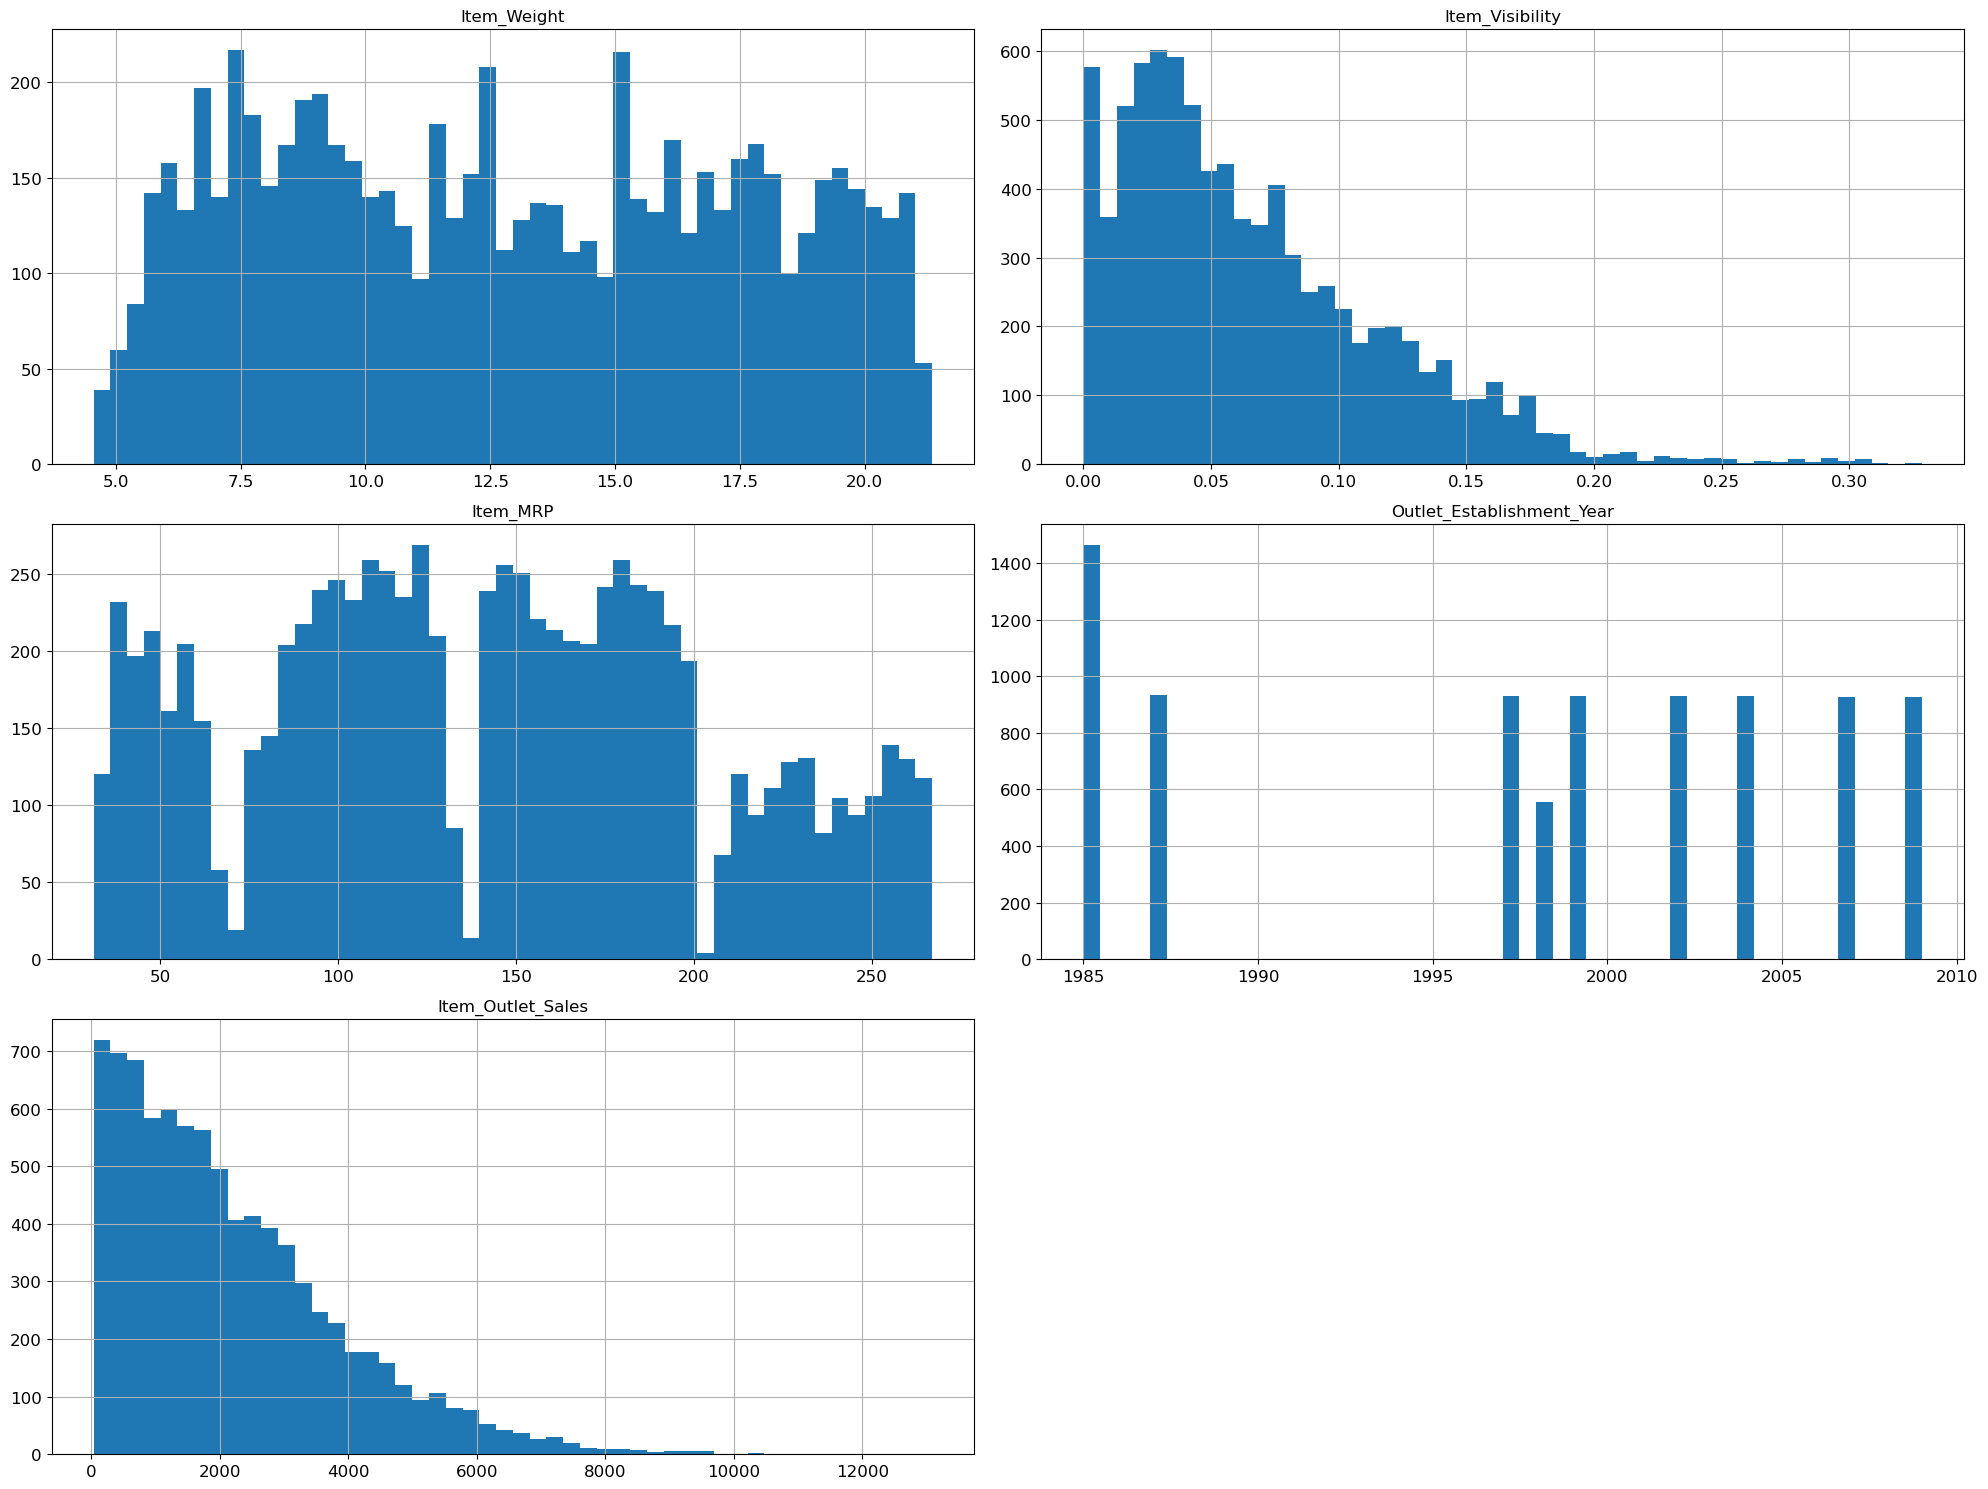

In [11]:
train_copy.hist(bins=50, figsize=(20,15))
save_fig("attribute_histgram_plots")

* `Item_Weight` uniform distribution
* `Item_Visibility` skewed right
* `Item_MSP` binned
* `Outlet_Establishment_Year` discrete
* `Item_Outlet_Sales` (target) skewed right

# Create a test set

* Test set has already been created, so not applicable here
* Option to create stratified validation set based on `Item_MRP` but will use cross-val instead

# EDA

## Looking for correlations

In [12]:
corr_matrix = train_copy.corr()

In [13]:
corr_matrix["Item_Outlet_Sales"].sort_values(ascending=False)

Item_Outlet_Sales            1.000000
Item_MRP                     0.567574
Item_Weight                  0.014123
Outlet_Establishment_Year   -0.049135
Item_Visibility             -0.128625
Name: Item_Outlet_Sales, dtype: float64

* As expected, `Item_MRP` biggest predictor of `Item_Outlet_Sales`

Saving figure scatter_matrix_plot


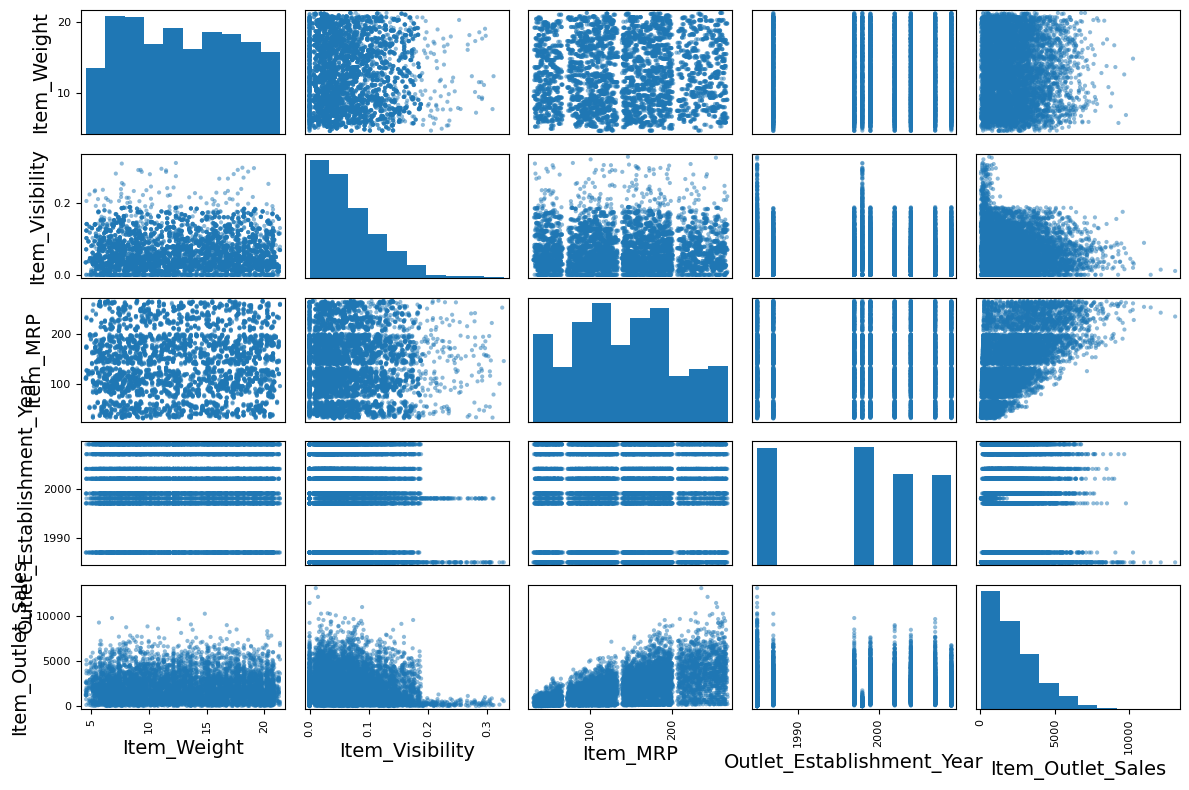

In [14]:
from pandas.plotting import scatter_matrix

scatter_matrix(train_copy, figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure sales_vs_mrp_scatterplot


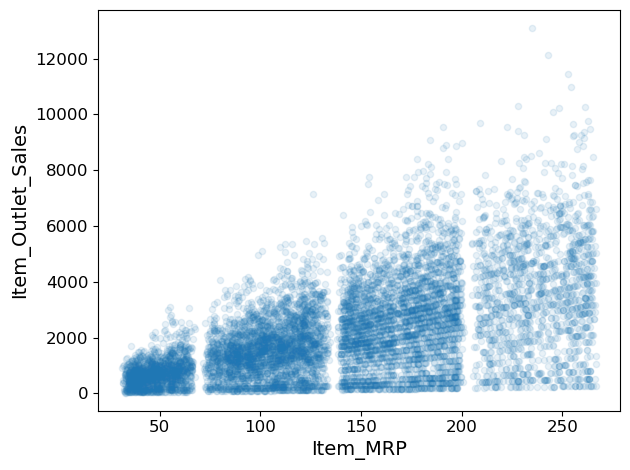

In [15]:
train_copy.plot(kind="scatter", x="Item_MRP", y="Item_Outlet_Sales",
            alpha=0.1)
save_fig("sales_vs_mrp_scatterplot")

* Vertical lines at varioust `Item_MRP` which could be an issue for the model

## Experimenting with attribute combinations

In [16]:
train_copy["Cost_Per_Weight"] = train_copy["Item_MRP"]/train_copy["Item_Weight"]

In [17]:
corr_matrix = train_copy.corr()
corr_matrix["Item_Outlet_Sales"].sort_values(ascending=False)

Item_Outlet_Sales            1.000000
Item_MRP                     0.567574
Cost_Per_Weight              0.421661
Item_Weight                  0.014123
Outlet_Establishment_Year   -0.049135
Item_Visibility             -0.128625
Name: Item_Outlet_Sales, dtype: float64

* `Cost_Per_Weight` better than `Item_Weight`, likely propped up by strong correlation of `Item_MRP`

<AxesSubplot:xlabel='Cost_Per_Weight', ylabel='Item_Outlet_Sales'>

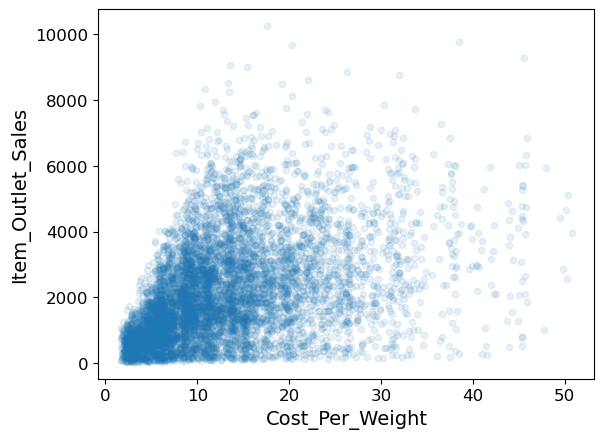

In [18]:
train_copy.plot(kind="scatter", x="Cost_Per_Weight", y="Item_Outlet_Sales",
            alpha=0.1)

In [19]:
train_copy.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Cost_Per_Weight
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000,7060.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914,12.745886
std,4.643456,0.051598,62.275067,8.371760,1706.499616,8.006126
min,4.555000,0.000000,31.290000,1985.000000,33.290000,1.686016
25%,8.773750,0.026989,93.826500,1987.000000,834.247400,6.777734
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000,11.000717
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400,16.343771
max,21.350000,0.328391,266.888400,2009.000000,13086.964800,50.775731


# Prepare the data for machine learning algorithms 

In [20]:
sales = train.drop("Item_Outlet_Sales", axis=1)  # drop labels for training set
sales_labels = train["Item_Outlet_Sales"].copy()

## Custom transformers

* Create a custom transformer to add extra attributes:

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

# Had to move this code up here because want to grab index from num_attribs not original dataframe
num_attribs = [cname for cname in sales.columns if sales[cname].dtype in ['int64', 'float64']]
cat_attribs = [cname for cname in sales.columns if sales[cname].dtype == "object"]

cat_attribs.remove('Item_Identifier')
cat_attribs.remove('Outlet_Identifier')

# See comment above
col_names = "Item_Weight", "Item_MRP"
weight_ix, mrp_ix = [
    num_attribs.index(c) for c in col_names] # get the column indices

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_cost_per_weight=True):  # no *args or **kwargs
        self.add_cost_per_weight = add_cost_per_weight
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        if self.add_cost_per_weight:
            Cost_Per_Weight = X[:, mrp_ix] / X[:, weight_ix]
            return np.c_[X, Cost_Per_Weight]
        else:
            return self

## Transformation pipelines

* Build a pipeline for preprocessing the numerical attributes:

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('num_imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [23]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot', OneHotEncoder()),
])

In [24]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

sales_prepared = full_pipeline.fit_transform(sales)

In [25]:
sales_prepared

<8523x37 sparse matrix of type '<class 'numpy.float64'>'
	with 85230 stored elements in Compressed Sparse Row format>

In [26]:
sales_prepared.shape

(8523, 37)

# Select and train a model 

## Fit models

In [27]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(sales_prepared, sales_labels)

LinearRegression()

In [28]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(sales_prepared, sales_labels)

DecisionTreeRegressor(random_state=42)

In [29]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(sales_prepared, sales_labels)

RandomForestRegressor(random_state=42)

In [30]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(sales_prepared, sales_labels)

SVR(kernel='linear')

## Cross-validation

In [31]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, sales_prepared, sales_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [32]:
tree_scores = cross_val_score(tree_reg, sales_prepared, sales_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [33]:
forest_scores = cross_val_score(forest_reg, sales_prepared, sales_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [34]:
svm_scores = cross_val_score(svm_reg, sales_prepared, sales_labels,
                         scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)

In [35]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [36]:
display_scores(lin_rmse_scores)

Scores: [1165.60475709 1140.75944161 1124.05417504 1119.45380526 1122.48130092
 1110.27231785 1115.80351951 1139.87962267 1139.58136969 1144.84862631]
Mean: 1132.2738935947646
Standard deviation: 15.923181459896593


In [37]:
display_scores(tree_rmse_scores)

Scores: [1595.4821218  1506.69664831 1580.9283393  1562.77700592 1564.15315242
 1532.16800827 1515.25518207 1601.66808437 1468.46498553 1548.65084704]
Mean: 1547.6244375032422
Standard deviation: 40.06500781991979


In [38]:
display_scores(forest_rmse_scores)

Scores: [1164.06960355 1134.32057423 1168.37872406 1106.82550992 1167.3559273
 1117.22059963 1112.4996962  1136.40050963 1117.6553762  1170.61812225]
Mean: 1139.5344642956156
Standard deviation: 24.471525761550023


In [39]:
display_scores(svm_rmse_scores)

Scores: [1300.77811361 1289.40549629 1219.93105481 1224.63093106 1180.77816926
 1247.47804587 1243.49371129 1266.11238374 1277.92926531 1266.80139317]
Mean: 1251.7338564403076
Standard deviation: 34.36738567569663


* Linear regression has lowest error, but bad choice because it includes negative predictions which is impossible for target
* Choose random forest model

# Fine-tune your model

## Randomized search

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),  # will use max of homl (8) and sqrt of feature space (6)
    }

forest_reg = RandomForestRegressor(random_state=42)  # re-fit without defining n_estimators
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(sales_prepared, sales_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001652574EE50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001652574E0A0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [41]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1121.6352384615952 {'max_features': 7, 'n_estimators': 180}
1159.7631881634613 {'max_features': 5, 'n_estimators': 15}
1139.736625021964 {'max_features': 3, 'n_estimators': 72}
1148.692646452877 {'max_features': 5, 'n_estimators': 21}
1123.4712975458333 {'max_features': 7, 'n_estimators': 122}
1139.4509101655424 {'max_features': 3, 'n_estimators': 75}
1139.1920819459979 {'max_features': 3, 'n_estimators': 88}
1126.836982542246 {'max_features': 5, 'n_estimators': 100}
1136.4202306384957 {'max_features': 3, 'n_estimators': 150}
1370.540470829481 {'max_features': 5, 'n_estimators': 2}


* Best performance with `max_features` = 7 and `n_estimators` = 180
* Both at top end of param range
* Opportunity to further optimize by shifting/ increasing param range
* Can expect RMSE of 1120 on test set

## Analyze the best models and their errors

In [42]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.06697826, 0.08239382, 0.30297922, 0.0450173 , 0.18296828,
       0.00321678, 0.00808295, 0.00761492, 0.00184076, 0.00180653,
       0.00478629, 0.00314546, 0.00244665, 0.00508474, 0.00606426,
       0.00586434, 0.00761695, 0.00270445, 0.00406115, 0.00604437,
       0.00377658, 0.00190579, 0.00180485, 0.00772818, 0.00461959,
       0.00298985, 0.00272553, 0.01329336, 0.00634571, 0.00861133,
       0.00562264, 0.0064774 , 0.00845918, 0.10067705, 0.02207241,
       0.0069698 , 0.04520329])

In [43]:
extra_attribs = ["Cost_Per_Weight"]
cat_encoder = full_pipeline.named_transformers_["cat"]["one_hot"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.30297921675453976, 'Item_MRP'),
 (0.18296828074268862, 'Cost_Per_Weight'),
 (0.08239381713020566, 'Item_Visibility'),
 (0.06697826292274443, 'Item_Weight'),
 (0.04501729983384468, 'Outlet_Establishment_Year'),
 (0.008082953615812388, 'Low Fat'),
 (0.0076149153483587445, 'Regular'),
 (0.003216778479886256, 'LF'),
 (0.0018407551333478839, 'low fat'),
 (0.0018065285371932401, 'reg')]

# Evaluate system on test set

## Generate predictions

In [44]:
final_model = rnd_search.best_estimator_

X_test = load_sales_data(SALES_PATH, 'test.csv')
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

 ## Create prediction file

In [45]:
Item_ID = X_test['Item_Identifier']
Outlet_ID = X_test['Outlet_Identifier']

submission_df_1 = pd.DataFrame({
    "Item_Identifier": Item_ID,
    "Outlet_Identifier": Outlet_ID,
    "Item_Outlet_Sales": final_predictions
})

submission_df_1.to_csv('submission_1.csv', index=False)

## Save model

In [46]:
import joblib

joblib.dump(final_model, "final_sales_model.pkl")

['final_sales_model.pkl']